# Basic API usage
# `torchcontrol` 


In [1]:
import sys; sys.path.append(1*'../') # go n dirs back

import torch
from torchdyn.numerics.odeint import odeint
from torchcontrol.systems.classic_control import Pendulum
from torchcontrol.controllers import *

%load_ext autoreload
%autoreload 2

In [2]:
# Change device according to your configuration
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu') # feel free to change :)

## Loading a system module

Here we load a system module and plot some random trajectories. The first example is the pendulum, described by the following equation:

$$\begin{equation}
    \begin{bmatrix} \dot{q}\\ \dot{p}\\ \end{bmatrix} = 
    \begin{bmatrix}
    0& 1/m \\
    -k& -\beta/m\\
    \end{bmatrix}
    \begin{bmatrix} q\\ p\\ \end{bmatrix} -
    \begin{bmatrix}
    0\\
    mgl \sin{q}\\
    \end{bmatrix}+
    \begin{bmatrix}
    0\\
    1\\
    \end{bmatrix} u
\end{equation}$$

In [3]:
?? Pendulum

Init signature:  Pendulum(*args, **kwargs)
Source:        
class Pendulum(ControlledSystemTemplate):
    """
    Inverted pendulum with torsional spring
    """
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)        
        self.m  = 1. 
        self.k  = 0.5
        self.l  = 1
        self.qr = 0
        self.beta  = 0.01
        self.g  = 9.81

    def dynamics(self, t, x):
        self.nfe += 1 # increment number of function evaluations
        u = self._evaluate_controller(t, x)

        # States
        q, p = x[..., :1], x[..., 1:]

        # Differential equations
        dq = p/self.m
        dp = -self.k*(q - self.qr) - self.m*self.g*self.l*sin(q)- self.beta*p/self.m + u
        self.cur_f = torch.cat([dq, dp], -1)
        return self.cur_f
File:           ~/Desktop/torchcontrol/torchcontrol/systems/classic_control.py
Type:           type
Subclasses:     


## Initial conditions
Now we can see how the system behaves with no control input in time. Let's declare some initial variables:

In [14]:
from math import pi as π

# Time span
dt = 0.05 # step size
t0, tf = 0, 10 # initial and final time
steps = int((tf - t0)/dt) + 1
t_span = torch.linspace(t0, tf, steps).to(device)

# Initial distribution
x_0 = π/2 # limit of the state distribution (in rads and rads/second)
init_dist = torch.distributions.Uniform(torch.Tensor([-x_0, -x_0]), torch.Tensor([x_0, x_0]))
x0 = init_dist.sample((50,)) # sample 50 trajectories

# Controller: we set it to 0
u = RandConstController()
u.u0 = 0.

# Instantiate the pendulum class
pendulum = Pendulum(u, solver='dopri5')

## Propagate the system forward
We have two ways to propagate the system forward:
1. Use `odeint` from `torchdyn` and forward propagate through the dynamics
2. Use the `forward` method of the base `ControlledSystemTemplate` class

In [15]:
# 1. odeint
traj_odeint = odeint(pendulum.dynamics, x0, t_span, solver='dopri5')[1]

# 2. forward
traj = pendulum(x0, t_span)

print(torch.equal(traj_odeint, traj))

True


## Plot trajectories

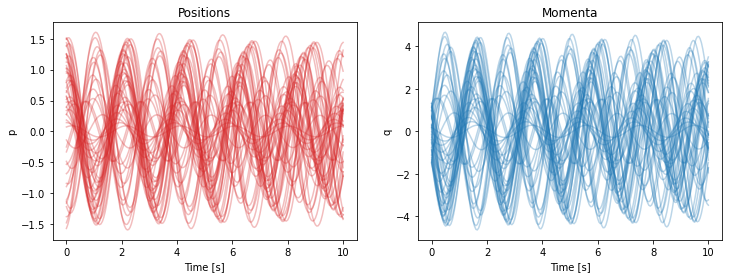

In [16]:
# Plotting
import matplotlib.pyplot as plt

def plot_pendulum_trajs():
    fig, axs = plt.subplots(1, 2, figsize=(12,4))
    for i in range(len(x0)):
        axs[0].plot(t_span.cpu(), traj[:,i,0].detach().cpu(), 'tab:red', alpha=.3)
        axs[1].plot(t_span.cpu(), traj[:,i,1].detach().cpu(), 'tab:blue', alpha=.3)
    axs[0].set_xlabel(r'Time [s]'); axs[1].set_xlabel(r'Time [s]')
    axs[0].set_ylabel(r'p'); axs[1].set_ylabel(r'q')
    axs[0].set_title(r'Positions'); axs[1].set_title(r'Momenta')

plot_pendulum_trajs()


## Accessing internal variables
We can also change the physical properties of the controlled system. For example, let's change the damping coefficient $\beta$:

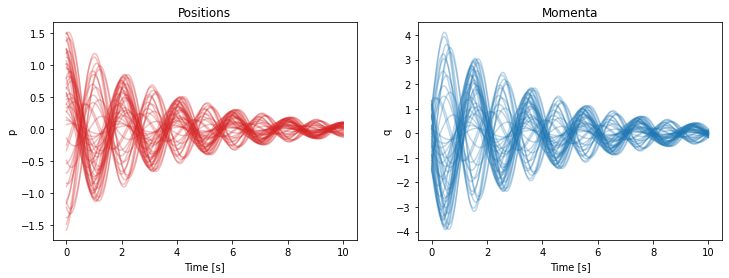

In [17]:
pendulum.beta = 0.5
traj = pendulum(x0, t_span)
plot_pendulum_trajs()

Here we change the pendulum's mass, which will modify its period:

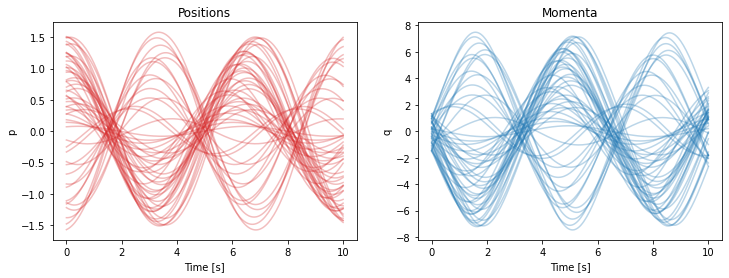

In [22]:
pendulum.beta = 0.01 # restore beta
pendulum.m = 5
traj = pendulum(x0, t_span)
plot_pendulum_trajs()